In [ ]:
%cd ..

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import os
import os.path as op
import mne
import numpy as np
import pandas as pd

In [2]:
%matplotlib qt

In [3]:
path = 'sessions/Erno/session_08/data.npy'

In [18]:
def loadData(path,tmin = 5):
    """
    Load the numpy session
    and convert it to mne dataset
    """
    test = np.load(path)
    EEG = test[2:]
    EEG.shape
    EEG/=1000*1000 #(µV->V)
    test[2:] = EEG


    sfreq = 250
    event_id = {"rest": 1, "left": 2, "right": 3, "trial_end": 10}


    ch_names = ["STIM", "Fz", "C3", "Cz", "C4", "Pz", "PO7", "Oz", "PO8"]  # documentation
    #ch_names = ["STIM", "Fp1", "FC1", "FC2", "FCz", "CPz", "CP1", "CP2", "Pz"] # API

    info = mne.create_info(ch_names=ch_names, sfreq=sfreq)

    raw = mne.io.RawArray(test[1:10], info) # Drop timestamp channel

    raw.crop(tmin=tmin)
    
    for ch in info.ch_names:
        if ch == 'STIM':
            raw.set_channel_types({ch:'stim'})
        else:
            raw.set_channel_types({ch:'eeg'})
    raw.set_montage('standard_1020')
    
    raw.describe()

    return raw

def filter(data):
    data = data.filter(8, 13, fir_design='firwin')
    data = data.notch_filter(50)

def create_epochs(data):
    event_dict = {'Rest': 1, 'Left': 2, 'Right': 3}#,'EndOfEvent': 10}
    mapping =  {1: 'Rest', 2: 'Left', 3: 'Right'}#, 10:'EndOfEvent'}
    events = mne.find_events(data,stim_channel='STIM')
    annot_from_events = mne.annotations_from_events(
        events=events, event_desc=mapping, sfreq=data.info['sfreq'])
    data.set_annotations(annot_from_events)
    data.drop_channels(["STIM", "Fz",  "Cz",  "Pz", "PO7", "Oz", "PO8"])
    return mne.Epochs(data, events, tmin=-0.3, tmax=2.0, event_id=event_dict,
                    preload=True)

In [ ]:
EEG_data = loadData(path, 40)
EEG_data.describe()

filter(EEG_data)
EEG_data.describe()

epochs = create_epochs(EEG_data)


Setting up band-pass filter from 8 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 13.00 Hz: -6.02, -6.02 dB



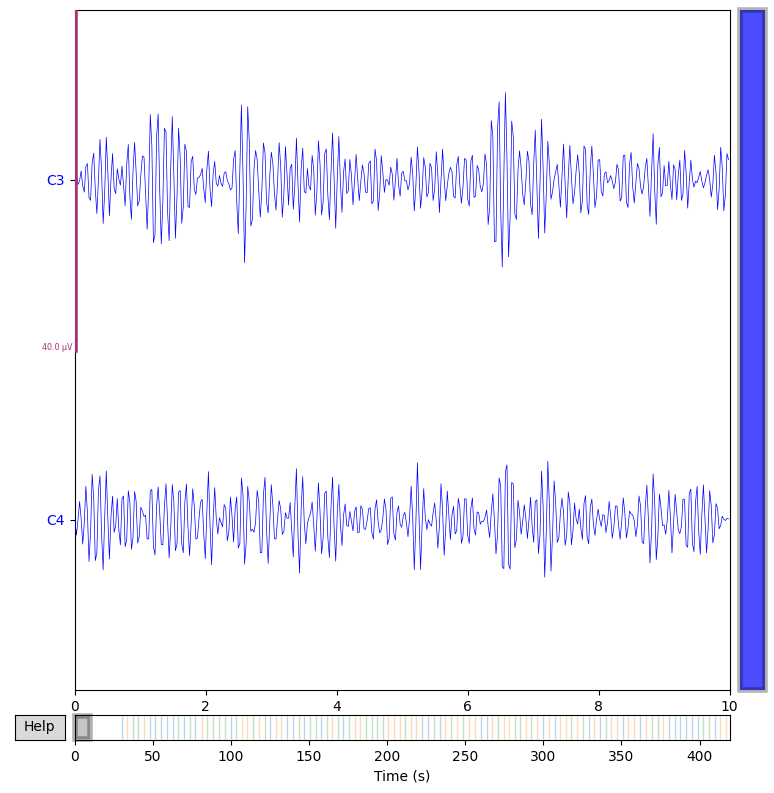

Channels marked as bad:
none


In [16]:
mne.viz.plot_raw(
    EEG_data, color=dict(eeg='b'),remove_dc=True, show_options=True, highpass=8.0, lowpass=13.0
)


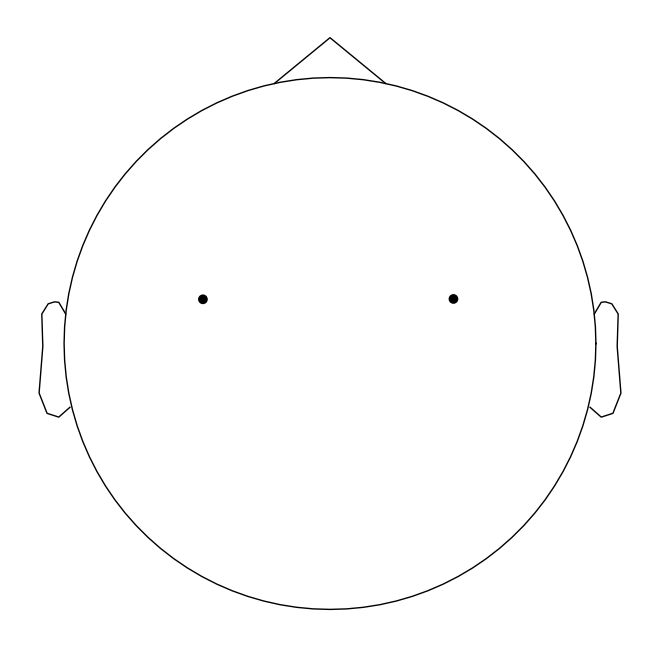

Channels marked as bad:
none


In [20]:
EEG_data.plot_sensors()

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


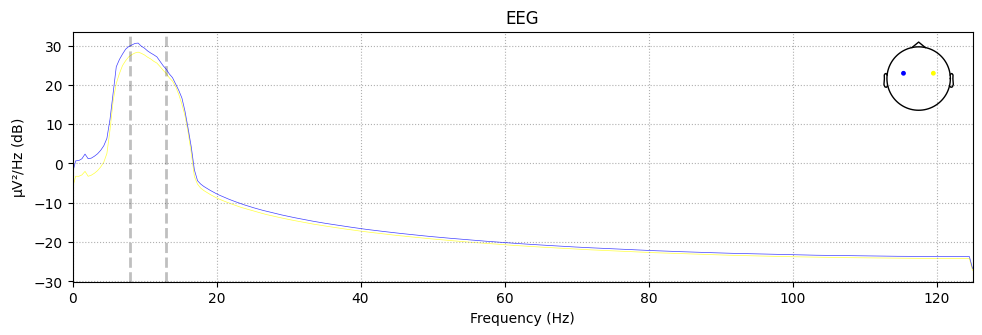

In [22]:
epochs['Left'].compute_psd().plot(picks='eeg')

In [23]:
epochs['Left'].plot_image()

Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


[<Figure size 640x480 with 3 Axes>]

In [24]:
epochs['Right'].plot_image()

Not setting metadata
38 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


[<Figure size 640x480 with 3 Axes>]

In [26]:
right_evoked = epochs['Right'].average()
left_evoked = epochs['Left'].average()
rest_evoked = epochs['Rest'].average()

mne.viz.plot_compare_evokeds(dict(left=left_evoked, right=right_evoked, rest=rest_evoked),
                             legend='upper left', show_sensors='upper right')


combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


[<Figure size 800x600 with 2 Axes>]

No projector specified for this dataset. Please consider the method self.add_proj.


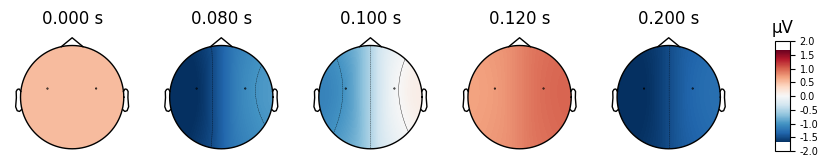

In [27]:
right_evoked.plot_joint(picks='eeg')
right_evoked.plot_topomap(times=[0., 0.08, 0.1, 0.12, 0.2], ch_type='eeg')

No projector specified for this dataset. Please consider the method self.add_proj.


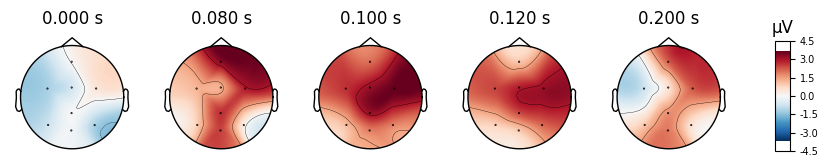

In [38]:
left_evoked.plot_joint(picks='eeg')
left_evoked.plot_topomap(times=[0., 0.08, 0.1, 0.12, 0.2], ch_type='eeg')

No projector specified for this dataset. Please consider the method self.add_proj.


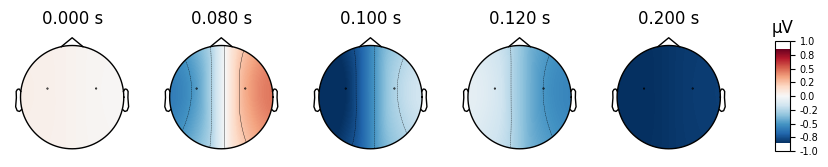

In [28]:
rest_evoked.plot_joint(picks='eeg')
rest_evoked.plot_topomap(times=[0., 0.08, 0.1, 0.12, 0.2], ch_type='eeg')